# Analyse SHAP values

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_preprocess import pipe_imputation_scaling, pipe_supervisedSelector
import shap
import pickle

from sklearn.pipeline import Pipeline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
translateVarsNames = {
    'creatinine_preop':"creatinine (preop)",
    'hgb_preop':"haemoglobin (preop)",
    'AGE':"age",
    'UPPER_ARM_ARRIVAL':"affected: upper arm",
    'LOWER_ARM_ARRIVAL':"affected: lower arm",
    'ANOGENITAL_ARRIVAL':"affected: anogenital area",
    'DIABETES':"diabetes",
    'SURGERY_BEFORE':"surgery before",
}

In [3]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
datasetTimepoint = "PRESURGERY"
target = "Conclusion_micro"
percentBoruta = 100
n_iter = 1000

''' 
Select features
'''
vars = f"{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc"    
varPath = f"{PATH}/results/20_featureSelection/{datasetTimepoint}/CV/{vars}.txt"
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()

''' 
Define paths
'''
folderFigures = f"{PATH}/figures/{datasetTimepoint}/40_internalValidation"
resultsPath = f"{PATH}/results/40_internalValidation/{datasetTimepoint}/"
dataPath = f"{PATH}/results/10_preprocessed"
dataset = f"{datasetTimepoint}_{target}_preprocessed.csv"

''' 
Split data
'''

with open(f"{PATH}/data/data_dtypes.json", "r") as f:
    dtypes = json.load(f)
data = pd.read_csv(f"{dataPath}/{dataset}", index_col=0, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())

X = data.drop(target, axis=1)
y = data[target]

In [4]:
''' Load SHAP'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_{model}_n{n_iter}_shap.pickle', 'rb') as f:
    dic_shap = pickle.load(f)
### sort
dic_shap = dict(sorted(dic_shap.items()))

average_shap_values = []
for k,v in dic_shap.items():
    average_shap_values.append(np.array(v).mean(axis=0)) 

In [6]:
''' 
Prepare dataframe for plotting
'''
num_columns = X.loc[:,sel_variables].select_dtypes(include=["float64"]).columns
bin_columns = X.loc[:,sel_variables].select_dtypes(include=["int64"]).columns
cat_columns = X.loc[:,sel_variables].select_dtypes(include=["object"]).columns
preprocessor = pipe_imputation_scaling(num_columns, bin_columns, cat_columns)  


pipe = Pipeline([("selector", pipe_supervisedSelector(sel_variables)),
                        ("imputation", preprocessor)])
X_imputed_plotting = pipe.fit_transform(X)
columnOrderAfterPreprocessing = [ele[5:] for ele in pipe["imputation"].get_feature_names_out()]
df_plotting = pd.DataFrame(X_imputed_plotting[list(dic_shap.keys())], columns=columnOrderAfterPreprocessing)

### INverse transform numerical variables to add to interpretability
num_inverseTransform = pipe[1].transformers_[0][1][0].inverse_transform(df_plotting.loc[:,pipe[1].transformers_[0][2].tolist()])
df_plotting.loc[:,pipe[1].transformers_[0][2].tolist()] = num_inverseTransform

df_plotting.columns = [translateVarsNames[ele] for ele in columnOrderAfterPreprocessing]
df_plotting

,creatinine (preop),haemoglobin (preop),age,affected: upper arm,affected: lower arm,affected: anogenital area,diabetes,surgery before
0,189.0,17.388,66.0,1.0,0.0,0.0,0.0,0.0
1,184.0,11.431,63.0,1.0,1.0,0.0,0.0,0.0
2,104.0,12.880,46.0,0.0,0.0,0.0,0.0,1.0
3,53.0,12.558,72.0,0.0,0.0,0.0,0.0,0.0
4,206.0,9.338,58.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
404,98.0,12.000,73.0,0.0,0.0,1.0,1.0,0.0
405,98.0,10.800,47.0,0.0,0.0,0.0,0.0,0.0
406,233.0,12.100,48.0,0.0,0.0,0.0,0.0,0.0
407,435.0,10.900,53.0,0.0,0.0,0.0,0.0,0.0


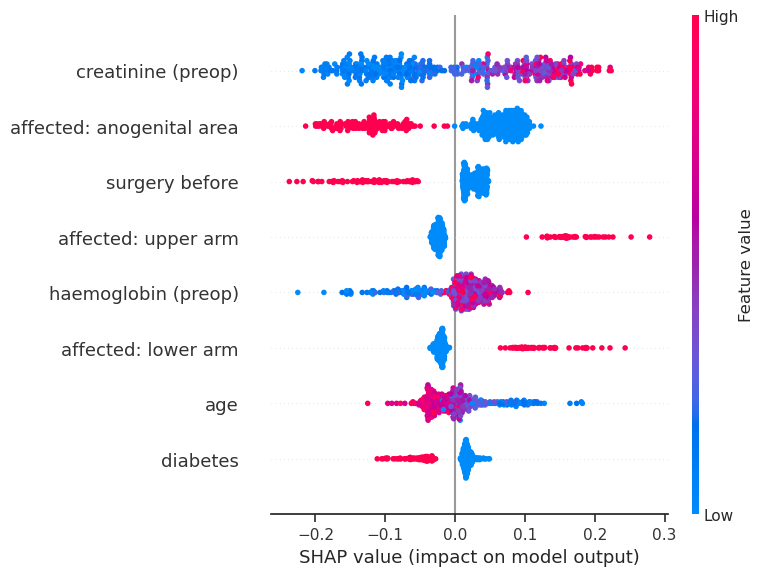

In [14]:
sns.set_theme(style="white", font_scale=1.2)
shap.summary_plot(np.array(average_shap_values), 
                  features=df_plotting,
                  show = False, sort=True, plot_size=(8.0,6.0))
#plt.title(f'{datasetTimepoint}')
plt.savefig(f"{folderFigures}/SHAP_n{n_iter}_{datasetTimepoint}.png", dpi=300)
plt.savefig(f"{folderFigures}/SHAP_n{n_iter}_{datasetTimepoint}.pdf", dpi=300)

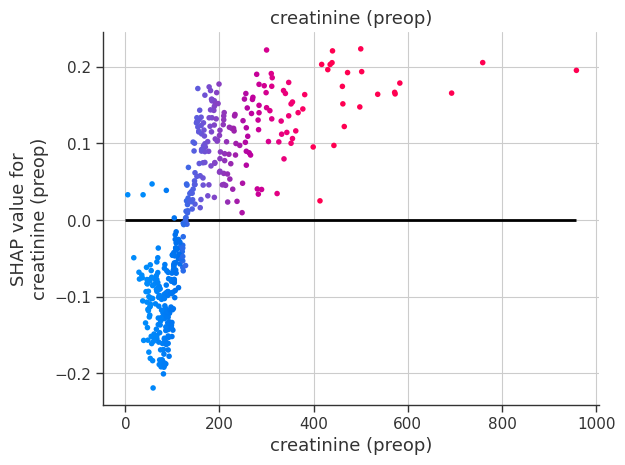

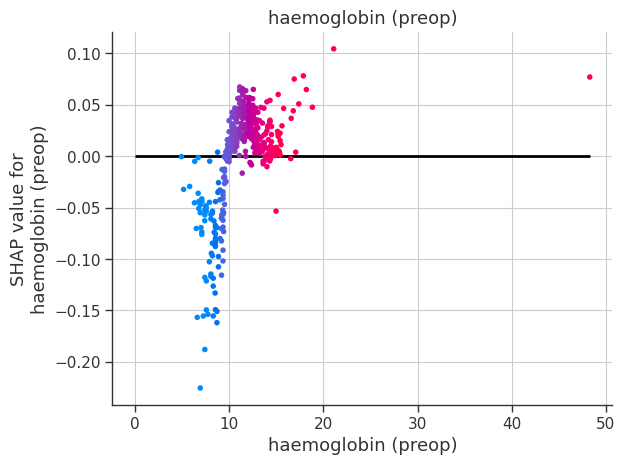

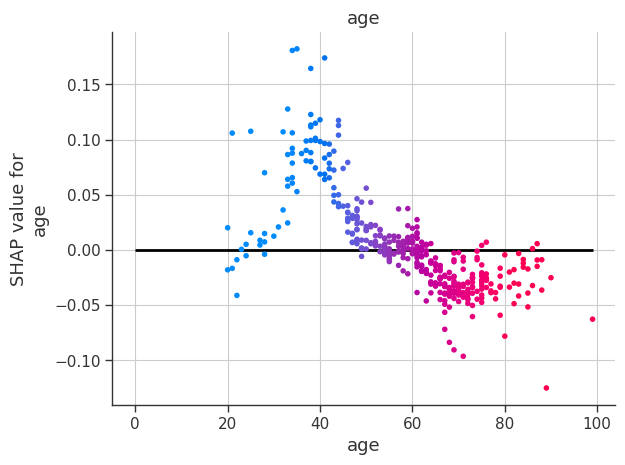

In [9]:
sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")

for i,a in enumerate(df_plotting.loc[:,["creatinine (preop)", "haemoglobin (preop)", "age"]]):
    fig, ax = plt.subplots(1,1)
    ax.hlines(y=0, xmin=0, xmax=df_plotting.loc[:,a].max(), linestyles="-", colors='black', alpha=1, linewidth=2,zorder=1)
    shap.dependence_plot(a, np.array(average_shap_values), 
                        df_plotting, 
                        interaction_index=a,
                        ax=ax, title=a, show=False)
    plt.tight_layout()
    plt.savefig(f"{folderFigures}/SHAP_dependencePlot_{a}.png", dpi=300)
    plt.savefig(f"{folderFigures}/SHAP_dependencePlot_{a}.pdf", dpi=300)

In [17]:
a = pd.DataFrame(average_shap_values, columns=df_plotting.columns).iloc[:,0]
a.index[a > 0]

Index([  0,   1,   4,   6,   7,   9,  11,  13,  16,  17,
       ...
       386, 387, 393, 398, 399, 400, 401, 406, 407, 408],
      dtype='int64', length=203)

In [24]:
df_plotting["creatinine (preop)"][a > 0].sort_values()[:20]

29     -50.778881
308    -23.864152
81      -2.034084
284     39.067388
309     40.229867
269     45.583263
311     63.666996
264     67.610712
273    104.000000
289    113.212639
312    119.979474
296    123.778038
164    128.000000
359    129.000000
280    129.000000
298    130.000000
361    130.000000
150    131.000000
77     132.000000
51     132.000000
Name: creatinine (preop), dtype: float64